# GASMAS

Date: 16/01/2025

Recolected data: 13/01/2025
on internet: https://colab.research.google.com/drive/1djV26jvRAwaaeW0MAl4zbxs0Z91--mve#scrollTo=nOliIFy9mtqH

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import os
import shutil

    

General description of the functions: 

csv_to_df: Reads a CSV file, skips the first row, and renames the columns for clarity.

creation_df_list: Takes a list of file paths and converts each CSV file into a DataFrame. Returns a list of DataFrames.

check_signal_down: Plots WMS and Direct signals when the signal is going down.

check_signal_up: Plots WMS and Direct signals when the signal is going up.

signals: Computes the normalized GASMAS signal and related metrics (s2f, sDir).

get_the_avg_of_the_list: Calculates and returns the average of a list of numbers.

organize_files_into_folders: Organizes files in the specified directory into subfolders, grouping them by a specified number of files per folder.

move_files_to_main_directory: Moves all files from subfolders to the main directory.

## Experiment



#### Functions 



In [39]:

# Function to transform the CSV to a DataFrame object
def csv_to_df(file_path):
    """
    This function reads a CSV file and processes it by renaming the columns.
    
    Parameters:
    - file_path: str, path to the CSV file
    
    Returns:
    - DataFrame: a processed pandas DataFrame with renamed columns
    """
    # Read the CSV file, skipping the first row (header is at row index 1)
    df = pd.read_csv(file_path, header=1)
    
    # Rename the columns for better clarity
    df = df.rename({"second": "x", "Volt": "Direct", "Volt.1": "WMS signal"}, axis=1)  # Wavelength-Modulation Spectroscopy (WMS)
    
    return df


# Function to create a list of DataFrames from multiple file paths
def creation_df_list(file_path):
    """
    This function processes a list of file paths and returns a list of DataFrames.
    
    Parameters:
    - file_paths: list of str, paths to the CSV files
    
    Returns:
    - list of DataFrame: list of DataFrames created from the CSV files
    """
    dfs = []  # Empty list to store DataFrames
    
    for file in file_path:
        # For each file path, convert CSV to DataFrame
        df = csv_to_df(file)
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    return dfs


# Function to plot the signals from DataFrames when the signal is going down
def check_signal_down(list_of_dfs, num_measurements):
    """
    This function generates plots of the 'WMS signal' and 'Direct signal' for each DataFrame in the list.
    It is specifically designed to show the behavior of signals during a downtrend.
    
    Parameters:
    - list_of_dfs: list of pandas DataFrames, each representing a different measurement
    - num_measurements: int, the number of foam measurements
    
    Returns:
    - None (Displays plots)
    """
    nrows = len(list_of_dfs)  # Number of subplots based on number of DataFrames
    
    plt.figure(figsize=(15, 18))  # Create a large figure to accommodate all subplots
    
    # Loop through each DataFrame and plot
    for i, df in enumerate(list_of_dfs):
        # Plot the WMS signal (first column)
        plt.subplot(nrows, 2, 2*i + 1)  # Subplot for WMS signal
        plt.plot(df.x, df['WMS signal'], label="WMS signal")
        plt.legend()
        plt.title(f"Measurement {i + 1}, # foam = {num_measurements-i}")
        plt.xlabel('Time (s)')
        plt.ylabel('Signal (Volt)')
        
        # Plot the Direct signal (second column)
        plt.subplot(nrows, 2, 2*i + 2)  # Subplot for Direct signal
        plt.plot(df.x, -df.Direct, label="Direct signal")  # Inverted Direct signal
        plt.legend()
        plt.title(f"Measurement {i + 1}, # foam = {num_measurements-i}")
        plt.xlabel('Time (s)')
        plt.ylabel('Signal (Volt)')
    
    # Adjust layout to prevent overlapping subplots
    plt.tight_layout()
    plt.show()


# Function to plot the signals from DataFrames when the signal is going up
def check_signal_up(list_of_dfs, begin_measure):
    """
    This function generates plots of the 'WMS signal' and 'Direct signal' for each DataFrame in the list.
    It is specifically designed to show the behavior of signals during an uptrend.
    
    Parameters:
    - list_of_dfs: list of pandas DataFrames, each representing a different measurement
    - begin_measure: int, the starting number of the foam measurements
    
    Returns:
    - None (Displays plots)
    """
    nrows = len(list_of_dfs)  # Number of subplots based on number of DataFrames
    
    plt.figure(figsize=(15, 18))  # Create a large figure to accommodate all subplots
    
    # Loop through each DataFrame and plot
    for i, df in enumerate(list_of_dfs):
        # Plot the WMS signal (first column)
        plt.subplot(nrows, 2, 2*i + 1)  # Subplot for WMS signal
        plt.plot(df.x, df['WMS signal'], label="WMS signal")
        plt.legend()
        plt.title(f"Measurement {i + 1}, # foam = {begin_measure+i}")
        plt.xlabel('Time (s)')
        plt.ylabel('Signal (Volt)')
        
        # Plot the Direct signal (second column)
        plt.subplot(nrows, 2, 2*i + 2)  # Subplot for Direct signal
        plt.plot(df.x, -df.Direct, label="Direct signal")  # Inverted Direct signal
        plt.legend()
        plt.title(f"Measurement {i + 1}, # foam = {begin_measure+i}")
        plt.xlabel('Time (s)')
        plt.ylabel('Signal (Volt)')
    
    # Adjust layout to prevent overlapping subplots
    plt.tight_layout()
    plt.show()


# Function to compute the normalized GASMAS signal and other related metrics
def signals(list_of_dfs):
    """
    This function computes the normalized GASMAS signal and related metrics (e.g., s2f, sDir).
    
    Parameters:
    - list_of_dfs: list of pandas DataFrames representing different measurements
    
    Returns:
    - gasmas: list of normalized GASMAS signals for each measurement
    - s2fCheckPoint: list of s2f values (calculated from max-min)
    - sDirCheckPoint: list of normalized 'Direct' signal values for normalization
    """
    gasmas = []  # List to store normalized GASMAS signals
    s2fCheckPoint = []  # List to store s2f values
    sDirCheckPoint = []  # List to store normalized Direct signal values
    
    for i, df in enumerate(list_of_dfs):
        # Drop NaN values from the 'WMS signal' column
        df = df.dropna(subset='WMS signal').reset_index(drop=True)

        # Define the max value of WMS signal
        WMSmax = df['WMS signal'].max()

        # Get the row(s) where WMS signal is at its maximum
        dfmaxs = df[(df['WMS signal'] == WMSmax)]
        newx = dfmaxs['x'].values  # X value for maximum WMS signal

        # Define ranges for finding the minimums before and after the max
        df_Filt1 = df[(df['x'] <= newx[0])]
        df_Filt2 = df[(df['x'] >= newx[0])]

        # Find the minimums in both filtered dataframes
        minimo11, minimo12 = df_Filt1['WMS signal'].min(), df_Filt2['WMS signal'].min()

        # Define sDir, which is the Direct signal at the maximum WMS
        sDir = -dfmaxs['Direct'].values
        sDirCheckPoint.append(sDir[0])

        # Compute the s2f value (signal-to-foam ratio)
        s2f = (np.abs(WMSmax - minimo11) + np.abs(WMSmax - minimo12)) / 2
        s2fCheckPoint.append(s2f)

        # Normalize the GASMAS signal
        sAbs = s2f / sDir[0]
        gasmas.append(sAbs)
    
    return gasmas, s2fCheckPoint, sDirCheckPoint


# Function to calculate the average of a list of numbers
def get_the_avg_of_the_list(list_name):
    """
    This function calculates the average of a list of numbers.
    
    Parameters:
    - list_name: list of numbers to calculate the average
    
    Returns:
    - average: the average of the numbers in the list
    """
    total = sum(list_name)  # Sum all the values in the list

    # Calculate the average
    average = total / len(list_name)
    return average


# Function to organize files into folders by grouping them into subfolders
def organize_files_into_folders(source_directory, files_per_folder):
    """
    This function organizes files in the specified directory into subfolders,
    with a specific number of files per subfolder.
    
    Parameters:
    - source_directory: str, the path to the directory containing the files
    - files_per_folder: int, the number of files to group together in each subfolder
    
    Returns:
    - None (Moves files into subfolders)
    """
    # List all files in the directory (only files, not directories)
    files = [f for f in os.listdir(source_directory) if os.path.isfile(os.path.join(source_directory, f))]
    
    # Sort the files alphabetically (optional)
    files.sort()
    print(f"Files to organize: {files}")

    # Folder counter to name subfolders
    folder_counter = 1

    # Process the files in chunks of `files_per_folder`
    for i in range(0, len(files), files_per_folder):
        # Create a new subfolder
        new_folder_name = f"folder_{folder_counter}"
        new_folder_path = os.path.join(source_directory, new_folder_name)
        os.makedirs(new_folder_path, exist_ok=True)
        
        # Move the files into the new folder
        for j in range(i, min(i + files_per_folder, len(files))):
            file_path = os.path.join(source_directory, files[j])
            shutil.move(file_path, os.path.join(new_folder_path, files[j]))

        # Increment the folder counter
        folder_counter += 1

    print(f"Files have been organized into {folder_counter - 1} folders.")


# Function to move all files from subfolders to the main directory
def move_files_to_main_directory(root_directory, main_directory):
    """
    This function moves all files from subfolders to the main directory.
    
    Parameters:
    - root_directory: str, the root directory containing subfolders
    - main_directory: str, the directory where files will be moved
    
    Returns:
    - None (Moves files to the main directory)
    """
    # Walk through all subdirectories and files
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            # Get the full path of the current file
            file_path = os.path.join(root, file)
            
            # Avoid moving files that are already in the main directory
            if not os.path.samefile(file_path, main_directory):
                # Move the file to the main directory
                shutil.move(file_path, os.path.join(main_directory, file))
    
    print("Files have been moved to the main directory.")



def get_subfolder_paths(directory_path):
    """
    This function returns a list of paths for all subfolders within the specified directory.
    """
    subfolder_paths = []
    # Iterate through the directory and get subfolder paths
    for root, dirs, _ in os.walk(directory_path):
        for dir_name in dirs:
            subfolder_paths.append(os.path.join(root, dir_name))
        break  # Remove this line if you want to include deeper subfolders
    return subfolder_paths

def process_csv_files_in_subfolders(directory_path):
    """
    This function processes CSV files from subfolders and collects various signals for plotting.
    It loads CSVs into dataframes, extracts signals, and calculates averages.
    """
    subfolder_paths = get_subfolder_paths(directory_path)  # Get paths of all subfolders
    list_of_csv_files = []  # Will store CSV file paths from subfolders
    gasmas_list, s2fCheckPoint_list, sDirCheckPoint_list = [], [], []  # Lists to store signals
    sDirCheckPoint_avg_list, gasmas_avg_list = [], []  # Lists to store averaged signals
    list_of_list_dfs_ = []  # Will store DataFrames

    # Iterate over each subfolder path
    for subfolder in subfolder_paths:
        # Get a sorted list of all CSV files in the subfolder
        csv_files = sorted(glob.glob(os.path.join(subfolder, '*.csv')))
        list_of_csv_files.append(csv_files)
    
    # Iterate over each list of CSV files
    for csv_files in list_of_csv_files:
        #To check function (OPTIONAL)
        # print(f"Processing CSV files in subfolder: \n {csv_files}")

        # Process CSV into DataFrames
        list_of_dfs_ = creation_df_list(csv_files)  # Assuming creation_df_list is a custom function
        gasmas_m1, s2fCheckPoint_m1, sDirCheckPoint_m1 = signals(list_of_dfs_)  # Assuming signals is a custom function

        # Append extracted signals to their respective lists
        gasmas_list.append(gasmas_m1)
        s2fCheckPoint_list.append(s2fCheckPoint_m1)
        sDirCheckPoint_list.append(sDirCheckPoint_m1)

    # Calculate averages for sDirCheckPoint and gasmas
    for avg_list in sDirCheckPoint_list:
        sDirCheckPoint_avg_m = get_the_avg_of_the_list(avg_list)  # Assuming get_the_avg_of_the_list is a custom function
        sDirCheckPoint_avg_list.append(sDirCheckPoint_avg_m)
        
    for avg_list in gasmas_list:
        gasmas_avg_m = get_the_avg_of_the_list(avg_list)
        gasmas_avg_list.append(gasmas_avg_m)

    # Return processed data for further use or plotting
    return list_of_csv_files, sDirCheckPoint_avg_list, gasmas_avg_list, gasmas_list

def bar_Error(pos, x_axis, gasmas_avg_list, var_list, alpha_value = 0.5):
    plt.errorbar(x_axis[pos], gasmas_avg_list[pos], yerr=np.sqrt(var_list[pos]), fmt='o', color='blue', alpha=alpha_value, capsize=5)

def plotting_signals(x_axis, sDirCheckPoint_avg_list, gasmas_avg_list, max_value_x, gasmas_list):
    """
    This function generates plots for the given signals.
    It creates a scatter plot for 'sDirCheckPoint_avg_list' and a linear fit plot for 'gasmas_avg_list'.
    """
    # Direct signal plot:
    print("x_axis es:", x_axis)
    print("dir signal",sDirCheckPoint_avg_list)
    plt.scatter(x_axis, sDirCheckPoint_avg_list)
    plt.xlabel("Distance to the base [cm]")  # Label for the x-axis
    plt.ylabel("Señal directa [V]")  # Label for the y-axis
    plt.show()

    # GASMAS signal plot:
    # Fit the linear regression model (adjusting x_axis and gasmas_avg_list)
    param = np.polyfit(x_axis, gasmas_avg_list, 1)  # Linear fit (y = mx + b)
    vec = np.linspace(0, max_value_x, 100)  # Create a range of x values for the fitted line
    y_1 = param[0] * vec + param[1]  # Calculate the corresponding y values using the linear model

    # Calculate the equivalent mean path length (EMPL)
    EMPL = param[1] / param[0]

    # Create the plot
    plt.plot(vec, y_1, label="Linear Fit", color='orange')  # Plot the fitted line
    #OPTIONAL to check the values of the points exactly
    ## print("gasmas avg list is:", gasmas_avg_list)
    plt.scatter(x_axis, gasmas_avg_list, label="Average Gasmas", color='blue')  # Scatter plot for gasmas signals
    #OPTIONAL to check the values of the points exactly
    ## print("GASMAS list is:", gasmas_list)
    vector_cm = []  # List to store vectors for each gasmas signal
    var_list = []
    

    # Create vectors (one for each gasmas signal) and append to vector_cm list
    for i in range(len(gasmas_list)):
        vector_cm_n = np.full_like(gasmas_list[i], x_axis[i])  # Create an array of the same size as gasmas signal, filled with x_axis[i]
        vector_cm.append(vector_cm_n)

    # Plot each gasmas signal with transparency (alpha value)
    alpha_value = 0.5  # Set transparency level (between 0 and 1)
    for it in range(len(gasmas_list)):
    # Uncomment the next loop if you want to plot gasmas signals with transparency
    #     plt.scatter(vector_cm[it], gasmas_list[it], alpha=alpha_value)
        var_m = np.var(gasmas_list[it])
        var_list.append(var_m)

    #Plot the error bar:
    for iter in range(len(x_axis)):
        bar_Error(iter,x_axis, gasmas_avg_list,var_list)
    # Print out the linear fit parameters (b = intercept, m = slope)
    print("b:", param[1])
    print("m:", param[0])

    # Print the equivalent mean path lengths (EMPL)
    print("The equivalent mean path lengths:", EMPL)

    # Customize the plot with labels, legend, and grid
    plt.xlabel("Num of foams (#) [cm]")  # Label for the x-axis
    plt.ylabel("Signal Gasmas")  # Label for the y-axis
    plt.legend(fontsize=8)  # Add a legend with a small font size
    plt.grid(True)  # Display grid lines

    # Show the plot
    plt.show()



### Standar Adition inverse 

In [40]:
# Just for the case that you have not ordered the files according the measurements taked:
"""
organize_files_into_folders
"""
source_directory = "GASMAS_05_01_25_CV/" 
files_per_folder = 6
organize_files_into_folders(source_directory, files_per_folder)

Files to organize: []
Files have been organized into 0 folders.


[11 10  9  8  7  6  5  4  3  2]
x_axis es: [11 10  9  8  7  6  5  4  3  2]
dir signal [np.float64(2.1230126833333336), np.float64(2.1787956666666664), np.float64(2.255714816666667), np.float64(2.3381257333333334), np.float64(2.4136769333333334), np.float64(2.55822395), np.float64(2.7847977499999996), np.float64(2.9088697833333335), np.float64(3.0846313666666663), np.float64(3.1569158500000003)]


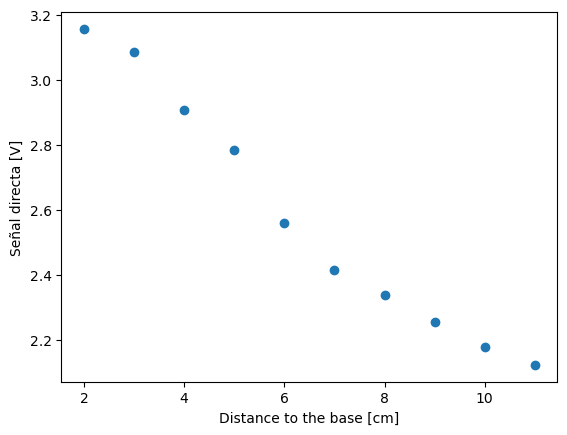

b: 14.756255971411626
m: 0.06451709301882462
The equivalent mean path lengths: 228.71855009192814


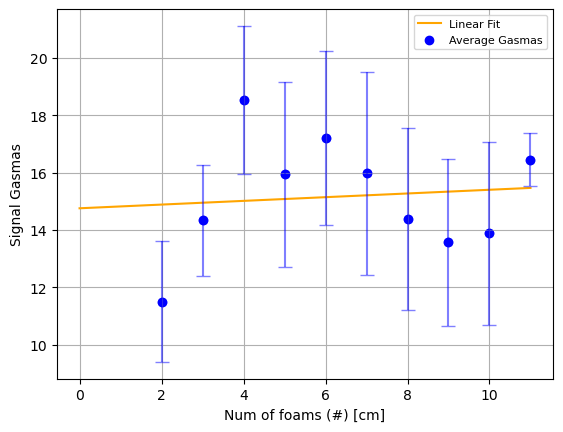

In [41]:




# You can now call the function:
directory_path = "GASMAS_05_01_25_CV/"
subfolder_paths = get_subfolder_paths(directory_path)
# print(subfolder_paths)

x_axis = np.arange(11, 1, -1)
print(x_axis)
list_of_csv_files, sDirCheckPoint_avg_list, gasmas_avg_list,gasmas_avg_m = process_csv_files_in_subfolders(directory_path)
max_value_x= 11
plotting = plotting_signals(x_axis, sDirCheckPoint_avg_list,gasmas_avg_list, max_value_x, gasmas_avg_m)

['GASMAS_30_01_2025/11cm', 'GASMAS_30_01_2025/10cm', 'GASMAS_30_01_2025/9cm', 'GASMAS_30_01_2025/8cm', 'GASMAS_30_01_2025/7cm', 'GASMAS_30_01_2025/6cm', 'GASMAS_30_01_2025/5cm', 'GASMAS_30_01_2025/3y5cm', 'GASMAS_30_01_2025/2y3cm', 'GASMAS_30_01_2025/1y5cm', 'GASMAS_30_01_2025/1']


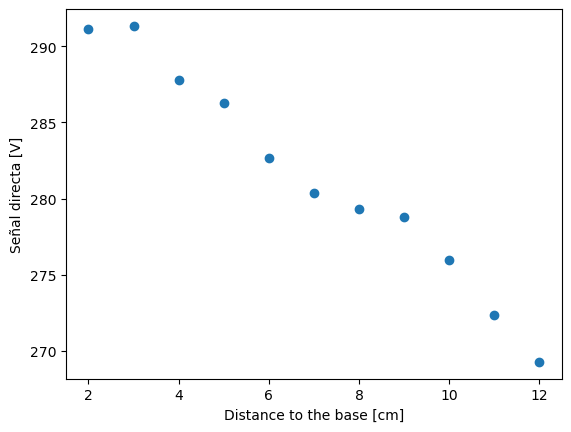

b: -7.43946455801768e-05
m: 4.264063921915557e-05
The equivalent mean path lengths: -1.7446887978817232


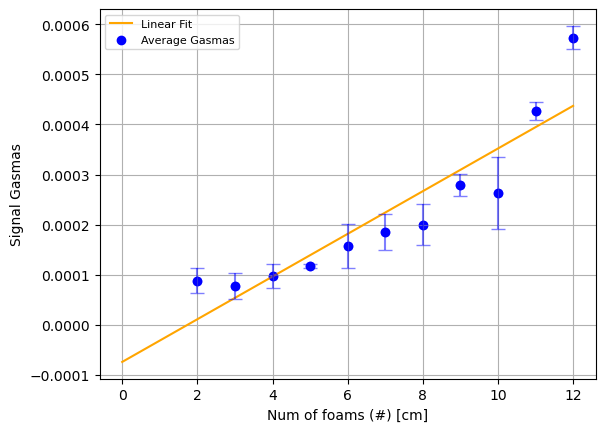

In [29]:
# You can now call the function:
directory_path = "GASMAS_30_01_2025/"
subfolder_paths = get_subfolder_paths(directory_path)
print(subfolder_paths)

x_axis = np.arange(12, 1, -1)
list_of_csv_files, sDirCheckPoint_avg_list, gasmas_avg_list,gasmas_avg_m = process_csv_files_in_subfolders(directory_path)
max_value_x= 12
plotting = plotting_signals(x_axis, sDirCheckPoint_avg_list,gasmas_avg_list, max_value_x, gasmas_avg_m)

## 02/06

In [30]:
# Just for the case that you have not ordered the files according the measurements taked:
"""
organize_files_into_folders
"""
source_directory = "GASMAS_06_02_2025/" 
files_per_folder = 4
organize_files_into_folders(source_directory, files_per_folder)

Files to organize: []
Files have been organized into 0 folders.


['GASMAS_06_02_2025/folder_1', 'GASMAS_06_02_2025/folder_2', 'GASMAS_06_02_2025/folder_3', 'GASMAS_06_02_2025/folder_4', 'GASMAS_06_02_2025/folder_5', 'GASMAS_06_02_2025/folder_6']


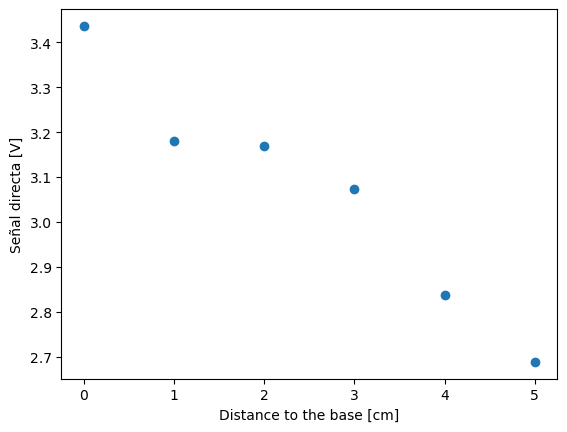

b: 16.665647717935897
m: 3.3171514395002117
The equivalent mean path lengths: 5.024084073908569


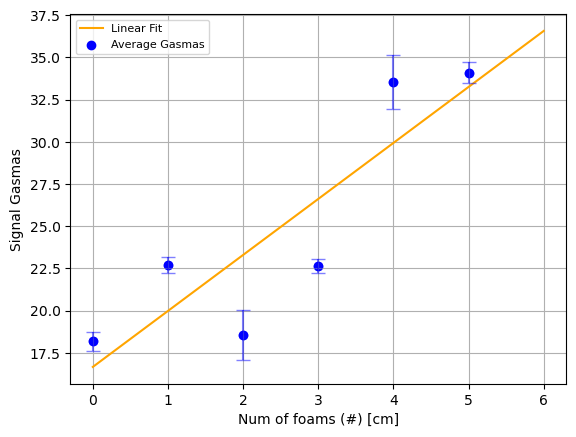

In [31]:
# You can now call the function:
directory_path = "GASMAS_06_02_2025/"
subfolder_paths = get_subfolder_paths(directory_path)
print(subfolder_paths)

x_axis = np.arange(0, 6, 1)
list_of_csv_files, sDirCheckPoint_avg_list, gasmas_avg_list,gasmas_avg_m = process_csv_files_in_subfolders(directory_path)
max_value_x= 6
plotting = plotting_signals(x_axis, sDirCheckPoint_avg_list,gasmas_avg_list, max_value_x, gasmas_avg_m)

## 02/06 2nd attempt:
About the equipment:

Gen. Func 4.59Hz | 01.1 vpp | 00.1DC

Gen. Func. Modulation: Freq: 5kHz |vhiz=+350 mVpp| 50 ohm| DC=0.00mv(0.00mv)| Sym=50.0% (50.0%)

Temp set = 19.06  Celsius  |    ILD= 99.31

Lock in: Time const: 1*10ms | 12db | Activate-sync
            Signal input: Input: A |Couple: AC| Ground: Float
            Reserve: Normal
            Filters: both
            Sensitivity: 1x10 microV , pA
            
Volt: -180


In [32]:
# Just for the case that you have not ordered the files according the measurements taked:
"""
organize_files_into_folders
"""
source_directory = "GASMAS_06_02_2025_2nd_no_avg/" 
files_per_folder = 6
organize_files_into_folders(source_directory, files_per_folder)

Files to organize: []
Files have been organized into 0 folders.


['GASMAS_06_02_2025_2nd_no_avg/folder_1', 'GASMAS_06_02_2025_2nd_no_avg/folder_2', 'GASMAS_06_02_2025_2nd_no_avg/folder_3', 'GASMAS_06_02_2025_2nd_no_avg/folder_4', 'GASMAS_06_02_2025_2nd_no_avg/folder_5', 'GASMAS_06_02_2025_2nd_no_avg/folder_6']


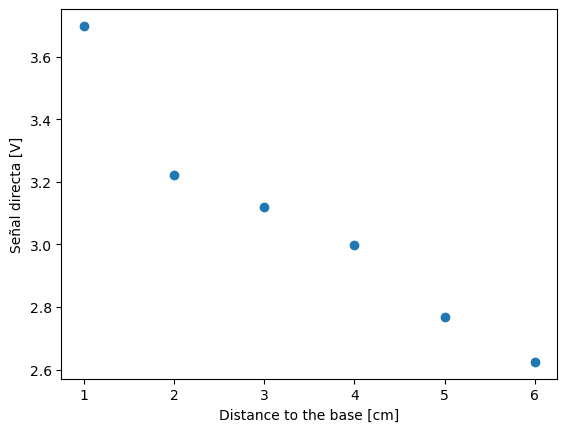

b: 12.94568519544085
m: 0.7406029902113795
The equivalent mean path lengths: 17.479925637008233


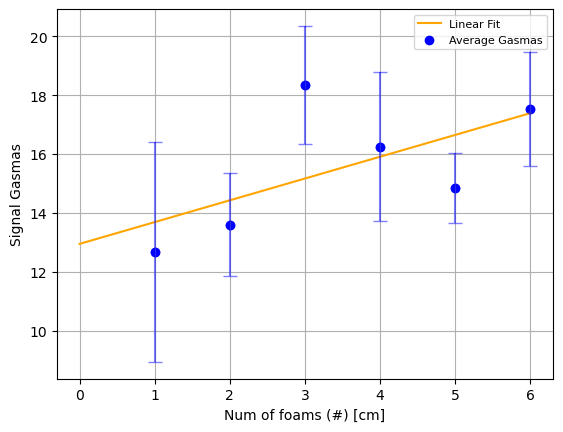

In [33]:
# You can now call the function:
directory_path = "GASMAS_06_02_2025_2nd_no_avg/"
subfolder_paths = get_subfolder_paths(directory_path)
print(subfolder_paths)

x_axis = np.arange(6, 0, -1)
list_of_csv_files, sDirCheckPoint_avg_list, gasmas_avg_list,gasmas_avg_m = process_csv_files_in_subfolders(directory_path)
max_value_x= 6
plotting = plotting_signals(x_axis, sDirCheckPoint_avg_list,gasmas_avg_list, max_value_x, gasmas_avg_m)

## 02/06 2nd attempt with avg each 8:
About the equipment:

Gen. Func 4.59Hz | 01.1 vpp | 00.1DC

Gen. Func. Modulation: Freq: 5kHz |vhiz=+350 mVpp| 50 ohm| DC=0.00mv(0.00mv)| Sym=50.0% (50.0%)

Temp set = 20.82  Celsius  |    ILD= 95.69

Lock in: Time const: 1*10ms | 12db | Activate-sync
            Signal input: Input: A |Couple: AC| Ground: Float
            Reserve: Normal
            Filters: both
            Sensitivity: 1x10 microV , pA
            
Volt: -180

Oscilloscope: Ch1:200mv | Ch2:50V | 97.00ms| 50ms

In [34]:
# Just for the case that you have not ordered the files according the measurements taked:
"""
organize_files_into_folders
"""
source_directory = "GASMAS_06_02_2025_2nd_avg/" 
files_per_folder = 6
organize_files_into_folders(source_directory, files_per_folder)

Files to organize: []
Files have been organized into 0 folders.


['GASMAS_06_02_2025_2nd_avg/folder_1', 'GASMAS_06_02_2025_2nd_avg/folder_2', 'GASMAS_06_02_2025_2nd_avg/folder_3', 'GASMAS_06_02_2025_2nd_avg/folder_4', 'GASMAS_06_02_2025_2nd_avg/folder_5', 'GASMAS_06_02_2025_2nd_avg/folder_6', 'GASMAS_06_02_2025_2nd_avg/folder_7', 'GASMAS_06_02_2025_2nd_avg/folder_8', 'GASMAS_06_02_2025_2nd_avg/folder_9']


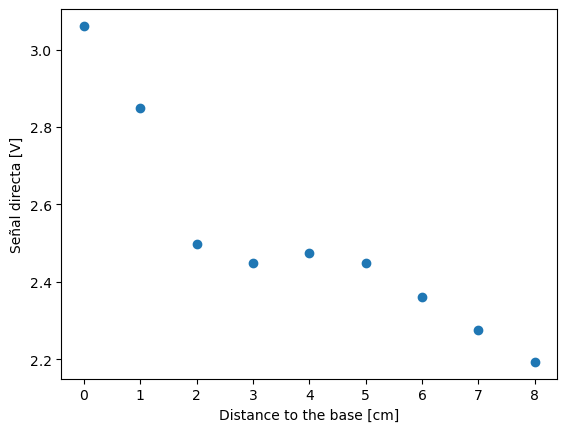

b: 15.79561792450791
m: 0.5766840968518502
The equivalent mean path lengths: 27.390417059768158


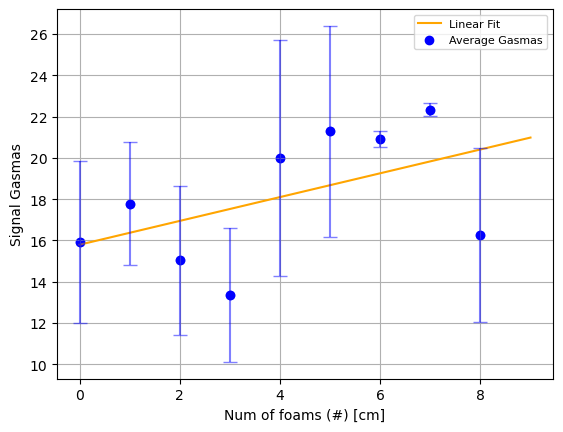

In [35]:
# You can now call the function:
directory_path = "GASMAS_06_02_2025_2nd_avg/"
subfolder_paths = get_subfolder_paths(directory_path)
print(subfolder_paths)

x_axis = np.arange(0, 9, 1)
list_of_csv_files, sDirCheckPoint_avg_list, gasmas_avg_list,gasmas_avg_m = process_csv_files_in_subfolders(directory_path)
max_value_x= 9
plotting = plotting_signals(x_axis, sDirCheckPoint_avg_list,gasmas_avg_list, max_value_x, gasmas_avg_m)